In [1]:
import os
from pathlib import Path
from functools import partial
from typing import Any, cast

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from src.model import Autoencoder
from src.datasets.mvtec_ad import MVTecAD
from src.persistence import load_model
from src.preprocessing import InferencePreprocessing

DATASET_DIR = Path(os.environ["AD_DATASET_DIR"])
SAVED_MODEL = Path("..") / os.environ["SAVED_MODEL"]
HISTORY_FILE = Path("..") / os.environ["HISTORY_FILE"]

<Axes: xlabel='epoch'>

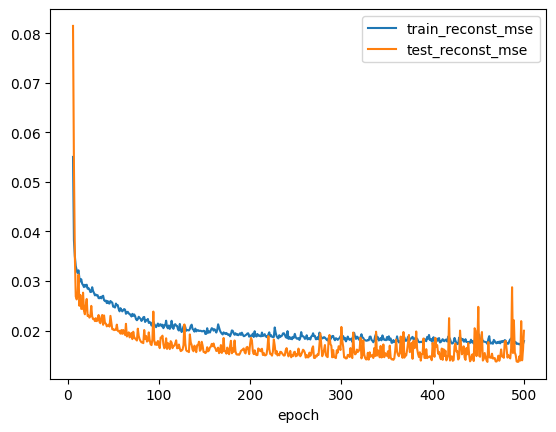

In [2]:
df_history = pd.read_csv(HISTORY_FILE)
df_history[df_history["epoch"] > 5].plot(x="epoch", y=["train_reconst_mse", "test_reconst_mse"])

In [3]:
def binary_labels(label: int) -> int:
    return 0 if label == 0 else 1

create_ds = partial(
        MVTecAD,
        dataset_dir=Path(os.environ["AD_DATASET_DIR"]),
        object=os.environ["AD_OBJECT"],
        sample_transform=InferencePreprocessing(
            target_img_width=int(os.environ["IMAGE_WIDTH"]),
            target_img_height=int(os.environ["IMAGE_HEIGHT"]),
        ),
        target_transform=binary_labels,
    )
ds_train, ds_test = create_ds(training_set=True), create_ds(training_set=False)

In [4]:
model = Autoencoder()
load_model(model, SAVED_MODEL)
model.eval()

Autoencoder(
  (encoder): Encoder(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=3)
    (1): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (2): ReLU()
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=64)
    (6): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=32)
    (11): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
    (12): ReLU()
    (13): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0,

Text(0.5, 1.0, 'Reconstructed')

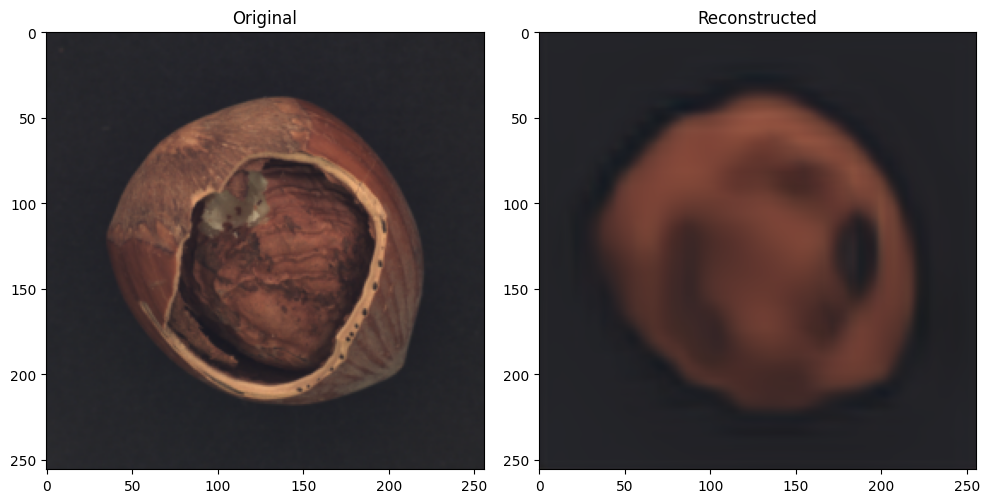

In [5]:
img_original, _ = cast(torch.Tensor, ds_test[52])
with torch.no_grad():
    img_reconstr = cast(torch.Tensor, model(img_original.unsqueeze(dim=0))).squeeze()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), tight_layout=True)
axs[0].imshow(img_original.movedim(0, -1))
axs[0].set_title("Original")
axs[1].imshow(img_reconstr.movedim(0, -1))
axs[1].set_title("Reconstructed")

In [6]:
data: dict[str, Any] = {"set": [], "idx": [], "loss": [], "label": []}

def perform_inference(ds: MVTecAD, set_name: str) -> None:
    loss_fn = torch.nn.MSELoss()

    for idx, (original, label) in enumerate(ds):
        with torch.no_grad():
            original = original.unsqueeze(dim=0)

            reconstructed = model(original)
            loss = loss_fn(reconstructed, original)
        
            data["set"].append(set_name)
            data["idx"].append(idx)
            data["loss"].append(loss.item())
            data["label"].append(label)

perform_inference(ds_train, "train")
perform_inference(ds_test, "test")

df = pd.DataFrame.from_dict(data)

In [7]:
df[["set", "loss"]].groupby("set").describe()

loss                                                              \
       count      mean       std       min       25%       50%       75%   
set                                                                        
test   110.0  0.002216  0.003135  0.000513  0.000804  0.000977  0.001465   
train  391.0  0.000781  0.000248  0.000389  0.000614  0.000736  0.000884   

                 
            max  
set              
test   0.015351  
train  0.002337

In [8]:
decision_boundary = df[df["set"] == "train"]["loss"].quantile(0.95)
df["prediction"] = 0
df.loc[df["loss"] > decision_boundary, "prediction"] = 1

In [9]:
df_test = df[df["set"] == "test"]

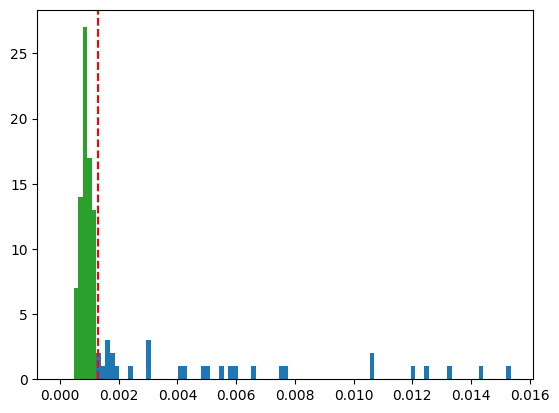

In [10]:
bins = np.linspace(0, df_test["loss"].max(), 100)
plt.hist(df_test[df_test["prediction"] == 0]["loss"], bins, color="tab:green")
plt.hist(df_test[df_test["prediction"] == 1]["loss"], bins, color="tab:blue")
plt.axvline(x=decision_boundary, color="r", linestyle="--")

In [11]:
accuracy = sum(df_test["label"] == df_test["prediction"]) / len(df_test)
accuracy

0.6363636363636364

In [12]:
df.sort_values(by="loss", ascending=False).head(10)

,set,idx,loss,label,prediction
499,test,108,0.015351,1,1
484,test,93,0.014291,1,1
491,test,100,0.013273,1,1
494,test,103,0.012540,1,1
492,test,101,0.012081,1,1
489,test,98,0.010561,1,1
485,test,94,0.010548,1,1
488,test,97,0.007737,1,1
439,test,48,0.007508,1,1
497,test,106,0.006606,1,1
